# Task 4.3P: Build your own image recognition system – Group Task

In [1]:
# Importing all the libraries...
import numpy as np
import cv2 as cv
import os
import matplotlib. pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

## 1. Data collection and annotation

In [2]:
tools = ['hammer', 'pliers', 'screw_driver', 'wrench']
path = 'ToolImages/'

def get_data(dir_name):
    file_names = []
    tool_labels = []
    for i in range(0, len(tools)):
        sub_path = path + dir_name + '/' + tools[i] + '/'
        sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
        sub_tool_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
        file_names += sub_file_names
        tool_labels += sub_tool_labels
    return (file_names, tool_labels)

"With this common function, we were able to create our three sets of data, as shown below: "

In [3]:
#Training Dataset...
training_data = get_data('Train')
training_file_names = training_data[0]
training_tool_labels = training_data[1]

In [4]:
print(training_file_names)

['ToolImages/Train/hammer/000002.jpg', 'ToolImages/Train/hammer/000013.jpg', 'ToolImages/Train/hammer/000014.jpg', 'ToolImages/Train/hammer/000015.jpg', 'ToolImages/Train/hammer/000016.jpg', 'ToolImages/Train/hammer/000017.jpg', 'ToolImages/Train/hammer/000018.jpg', 'ToolImages/Train/hammer/000020.jpg', 'ToolImages/Train/hammer/000022.jpg', 'ToolImages/Train/hammer/000037.jpg', 'ToolImages/Train/hammer/000042.jpg', 'ToolImages/Train/hammer/000046.jpg', 'ToolImages/Train/hammer/000047.jpg', 'ToolImages/Train/hammer/000048.jpg', 'ToolImages/Train/hammer/000049.jpg', 'ToolImages/Train/hammer/000052.jpg', 'ToolImages/Train/hammer/000053.jpg', 'ToolImages/Train/hammer/000061.jpg', 'ToolImages/Train/hammer/000063.jpg', 'ToolImages/Train/hammer/000069.jpg', 'ToolImages/Train/hammer/000070.jpg', 'ToolImages/Train/hammer/000071.jpg', 'ToolImages/Train/hammer/000072.jpg', 'ToolImages/Train/hammer/000074.jpg', 'ToolImages/Train/hammer/000075.jpg', 'ToolImages/Train/hammer/000083.jpg', 'ToolImages

In [5]:
#Validation Dataset...
validation_data = get_data('Val')
val_file_names = validation_data[0]
val_tool_labels = validation_data[1]

In [6]:
print(val_file_names)

['ToolImages/Val/hammer/000003.jpg', 'ToolImages/Val/hammer/000005.jpg', 'ToolImages/Val/hammer/000007.jpg', 'ToolImages/Val/hammer/000008.jpg', 'ToolImages/Val/hammer/000011.jpg', 'ToolImages/Val/hammer/000025.jpg', 'ToolImages/Val/hammer/000027.jpg', 'ToolImages/Val/hammer/000029.jpg', 'ToolImages/Val/hammer/000034.jpg', 'ToolImages/Val/hammer/000035.jpg', 'ToolImages/Val/hammer/000054.jpg', 'ToolImages/Val/hammer/000055.jpg', 'ToolImages/Val/hammer/000056.jpg', 'ToolImages/Val/hammer/000057.jpg', 'ToolImages/Val/hammer/000058.jpg', 'ToolImages/Val/hammer/000076.jpg', 'ToolImages/Val/hammer/000077.jpg', 'ToolImages/Val/hammer/000079.jpg', 'ToolImages/Val/hammer/000080.jpg', 'ToolImages/Val/hammer/000081.jpg', 'ToolImages/Val/hammer/000095.jpg', 'ToolImages/Val/hammer/000097.jpg', 'ToolImages/Val/hammer/000099.jpg', 'ToolImages/Val/hammer/000100.jpg', 'ToolImages/Val/hammer/000104.jpg', 'ToolImages/Val/hammer/000141.jpg', 'ToolImages/Val/hammer/000151.jpg', 'ToolImages/Val/hammer/0001

In [7]:
#Testing Dataset...
testing_data = get_data('Test')
test_file_names = testing_data[0]
test_tool_labels = testing_data[1]

In [8]:
print(test_file_names)

['ToolImages/Test/hammer/0000273.jpg', 'ToolImages/Test/hammer/000117.jpg', 'ToolImages/Test/hammer/000118.jpg', 'ToolImages/Test/hammer/000120.jpg', 'ToolImages/Test/hammer/000121.jpg', 'ToolImages/Test/hammer/000122.jpg', 'ToolImages/Test/hammer/000126.jpg', 'ToolImages/Test/hammer/000127.jpg', 'ToolImages/Test/hammer/000129.jpg', 'ToolImages/Test/hammer/000134.jpg', 'ToolImages/Test/hammer/000135.jpg', 'ToolImages/Test/hammer/000153.jpg', 'ToolImages/Test/hammer/000154.jpg', 'ToolImages/Test/hammer/000155.jpg', 'ToolImages/Test/hammer/000167.jpg', 'ToolImages/Test/hammer/000169.jpg', 'ToolImages/Test/hammer/000170.jpg', 'ToolImages/Test/hammer/000176.jpg', 'ToolImages/Test/hammer/000177.jpg', 'ToolImages/Test/hammer/000187.jpg', 'ToolImages/Test/hammer/000192.jpg', 'ToolImages/Test/hammer/000203.jpg', 'ToolImages/Test/hammer/000205.jpg', 'ToolImages/Test/hammer/000208.jpg', 'ToolImages/Test/hammer/000209.jpg', 'ToolImages/Test/hammer/000211.jpg', 'ToolImages/Test/hammer/000214.jpg',

## 2. Building image recognition application

### 2.1: Building BoW model

In [9]:
class Dictionary(object):
    def __init__(self, name, img_filenames):
        self.name = name # name of your dictionary
        self.img_filenames = img_filenames # list of image filenames
        # self.num_words = num_words # the number of words
        self.training_data = [] # this is the training data required by the K-Means algorithm
        self.words = [] # list of words, which are the centroids of clusters
        
    def elbow(self):
        sift = cv.xfeatures2d.SIFT_create()

        num_keypoints = [] # this is used to store the number of keypoints in each image
        training_data = []

        # load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    training_data.append(des)
                    
        Sum_of_squared_distances = []
        # K = [30, 40, 50, 60, 70, 80, 90, 100, 110, 125, 135, 150, 160, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
        # K = [50, 75, 100, 110, 125, 135, 150, 160, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
        K = [50, 75, 100, 110, 125, 135, 150, 160, 175, 190, 200, 210, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
        for k in K:
            km = KMeans(n_clusters=k)
            km = km.fit(training_data)
            Sum_of_squared_distances.append(km.inertia_)

        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum of squared distances')
        plt.title('Elbow Method For Optimal k')
        plt.show()

    def learn(self, num_words):
        sift = cv.xfeatures2d.SIFT_create()

        num_keypoints = [] # this is used to store the number of keypoints in each image

        # load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)

        # cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_

        # create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            # for each file, create a histogram
            histogram = np.zeros(num_words, np.float32)
            # if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)

        return training_word_histograms

    def create_word_histograms(self, img_filenames, num_words):
        sift = cv.xfeatures2d.SIFT_create()
        histograms = []

        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            histogram = np.zeros(num_words, np.float32) # word histogram for the input image

            if descriptors is not None:
                for des in descriptors:
                    # find the best matching word
                    min_distance = 1111111 # this can be any large number
                    matching_word_ID = -1 # initial matching_word_ID=-1 means no matching

                    for i in range(0, num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
                    histogram[matching_word_ID] += 1
                histogram /= len(descriptors) #normalise histogram to frequencies
            histograms.append(histogram)
        return histograms

In [10]:
dictionary_name = 'tools_train'
dictionary = Dictionary(dictionary_name, training_file_names)

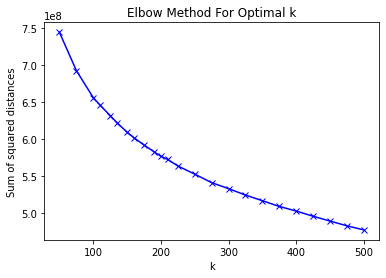

In [11]:
#Using the Elbow Method...

#Using K = [50, 75, 100, 110, 125, 135, 150, 160, 175, 190, 200, 210, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
dictionary.elbow()

"From here, we can see that the least convergence in this figure is at a value at 190. We will use this value to derive the training histograms."

In [12]:
training_word_histograms = dictionary.learn(190)

In [13]:
dictionary_name = 'tools_validation'
val_dictionary = Dictionary(dictionary_name, val_file_names)
val_word_histograms = val_dictionary.learn(190)

### 2.2: Building classifiers

#### 2.2.1: Using Linear Kernel SVM

"For Hypertuning, we are going to employ a Grid Search and find the best possible hyperparameters."

In [14]:
#Now by hypertuning the parameters, we can find the best possible value of C from the Validation dataset...
from sklearn.model_selection import GridSearchCV

In [39]:
# Creating the hyperparameter grid
c_space = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': c_space}

# Instantiating SVM classifier
svc = svm.SVC(kernel = 'linear')

# Instantiating the GridSearchCV object with the Validation Dataset
svc_cv = GridSearchCV(svc, param_grid, scoring = 'accuracy', cv = 5)
svc_cv.fit(val_word_histograms, val_tool_labels)

# Print the tuned parameters and score
print("Tuned Linear Kernel SVM Parameters: {}".format(svc_cv.best_params_))
print("Best score is {}".format(svc_cv.best_score_))

Tuned Linear Kernel SVM Parameters: {'C': 10}
Best score is 0.5416666666666666


"After hyperparameter tuning, the suitable value for C for our Linear SVM is 100. Now we will apply this value to the training of the model."

In [16]:
svm_classifier = svm.SVC(C = svc_cv.best_score_, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_tool_labels)

SVC(C=0.5416666666666666, kernel='linear')

#### 2.2.2: Using K- Nearest Neighbours

In [47]:
# Creating the hyperparameter grid
k_space =  [4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]
param_grid = {'n_neighbors': k_space}

# Instantiating KNN classifier
knn = KNeighborsClassifier()

# Instantiating the GridSearchCV object with the Validation Dataset
knn_cv = GridSearchCV(knn, param_grid, scoring = 'accuracy', cv = 5)
knn_cv.fit(val_word_histograms, val_tool_labels)

# Print the tuned parameters and score
print("Tuned K- Nearest Neighbours Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned K- Nearest Neighbours Parameters: {'n_neighbors': 5}
Best score is 0.45833333333333337


"After hyperparameter tuning, the suitable value for the nearest neighbours for our KNN is 15. Now we will apply this value to the training of the model."

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors = 15)
knn_classifier.fit(training_word_histograms, training_tool_labels)

KNeighborsClassifier(n_neighbors=15)

#### 2.2.3: Using AdaBoost

In [52]:
# Creating the hyperparameter grid
n_space =  [150, 160, 165, 170, 175, 180, 200, 250]
param_grid = {'n_estimators': n_space}

# Instantiating SVM classifier
adb = AdaBoostClassifier(random_state = 0)

# Instantiating the GridSearchCV object with the Validation Dataset
adb_cv = GridSearchCV(adb, param_grid, scoring = 'accuracy', cv = 5)
adb_cv.fit(val_word_histograms, val_tool_labels)

# Print the tuned parameters and score
print("Tuned AdaBoost Parameters: {}".format(adb_cv.best_params_))
print("Best score is {}".format(adb_cv.best_score_))

Tuned AdaBoost Parameters: {'n_estimators': 170}
Best score is 0.5416666666666667


"After hyperparameter tuning, the suitable value for n_estimators for our AdaBoost is .... Now we will apply this value to the training of the model."

In [21]:
adb_classifier = AdaBoostClassifier(n_estimators = 150, random_state = 0)
adb_classifier.fit(training_word_histograms, training_tool_labels)

AdaBoostClassifier(n_estimators=150, random_state=0)

### 2.3: Evaluating classifiers

In [22]:
dictionary_name = 'tools_testing'
test_dictionary = Dictionary(dictionary_name, val_file_names)
test_word_histograms = test_dictionary.learn(190)

In [23]:
print("Total number of Food Items from the testing dataset: ", len(test_tool_labels))

Total number of Food Items from the testing dataset:  128


#### 2.2.1: Evaluating our Linear SVM Model

In [24]:
num_words = 190
word_histograms = dictionary.create_word_histograms(test_file_names, num_words)
svm_predicted_tool_labels = svm_classifier.predict(word_histograms)

In [25]:
#Plotting the Confusion Matrix and Classification Report...
cm = confusion_matrix(test_tool_labels, svm_predicted_tool_labels)
print("------------------CONFUSION MATRIX FROM SVM--------------------\n")
print(cm)

ca = classification_report(test_tool_labels, svm_predicted_tool_labels)
print("\n\n------------------CLASSIFICATION RESULTS--------------------\n\n")
print(ca)

------------------CONFUSION MATRIX FROM SVM--------------------

[[ 0  0  0 32]
 [ 0  0  0 32]
 [ 0  0  0 32]
 [ 0  0  0 32]]


------------------CLASSIFICATION RESULTS--------------------


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        32
           3       0.25      1.00      0.40        32

    accuracy                           0.25       128
   macro avg       0.06      0.25      0.10       128
weighted avg       0.06      0.25      0.10       128



C:\Users\Sohaib bin Kashif\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohaib bin Kashif\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohaib bin Kashif\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#Computing the recognition Accuracy with the help of the Confusion Matrix...
recog_acc = (cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]) / len(test_tool_labels)
print("Recognition Accuracy: ", round(recog_acc,4) * 100,"%")

Recognition Accuracy:  25.0 %


#### 2.2.2: Evaluating our KNN Model 

In [27]:
num_words = 190
word_histograms = dictionary.create_word_histograms(test_file_names, num_words)
knn_predicted_tool_labels = knn_classifier.predict(word_histograms)

In [28]:
#Plotting the Confusion Matrix and Classification Report...
cm = confusion_matrix(test_tool_labels, knn_predicted_tool_labels)
print("------------------CONFUSION MATRIX FROM KNN--------------------\n")
print(cm)

ca = classification_report(test_tool_labels, knn_predicted_tool_labels)
print("\n\n------------------CLASSIFICATION RESULTS--------------------\n\n")
print(ca)

------------------CONFUSION MATRIX FROM KNN--------------------

[[ 8 21  0  3]
 [ 2 30  0  0]
 [ 6 23  3  0]
 [ 9 15  0  8]]


------------------CLASSIFICATION RESULTS--------------------


              precision    recall  f1-score   support

           0       0.32      0.25      0.28        32
           1       0.34      0.94      0.50        32
           2       1.00      0.09      0.17        32
           3       0.73      0.25      0.37        32

    accuracy                           0.38       128
   macro avg       0.60      0.38      0.33       128
weighted avg       0.60      0.38      0.33       128



In [29]:
#Computing the recognition Accuracy with the help of the Confusion Matrix...
recog_acc = (cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]) / len(test_tool_labels)
print("Recognition Accuracy: ", round(recog_acc,4) * 100,"%")

Recognition Accuracy:  38.279999999999994 %


#### 2.2.3: Evaluating our AdaBoost Model

In [30]:
num_words = 190
word_histograms = dictionary.create_word_histograms(test_file_names, num_words)
adb_predicted_tool_labels = adb_classifier.predict(word_histograms)

In [31]:
#Plotting the Confusion Matrix and Classification Report...
cm = confusion_matrix(test_tool_labels, adb_predicted_tool_labels)
print("------------------CONFUSION MATRIX FROM AdaBoost--------------------\n")
print(cm)

ca = classification_report(test_tool_labels, adb_predicted_tool_labels)
print("\n\n------------------CLASSIFICATION RESULTS--------------------\n\n")
print(ca)

------------------CONFUSION MATRIX FROM AdaBoost--------------------

[[13  1  7 11]
 [ 8 11 11  2]
 [10  0 19  3]
 [ 4  0  6 22]]


------------------CLASSIFICATION RESULTS--------------------


              precision    recall  f1-score   support

           0       0.37      0.41      0.39        32
           1       0.92      0.34      0.50        32
           2       0.44      0.59      0.51        32
           3       0.58      0.69      0.63        32

    accuracy                           0.51       128
   macro avg       0.58      0.51      0.51       128
weighted avg       0.58      0.51      0.51       128



In [32]:
#Computing the recognition Accuracy with the help of the Confusion Matrix...
recog_acc = (cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]) / len(test_tool_labels)
print("Recognition Accuracy: ", round(recog_acc,4) * 100,"%")

Recognition Accuracy:  50.78 %


## 3. Documentation

"Please refer to the attached report for this heading."